# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from ipywidgets import interactive
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

CUST_ID  ACCOUNT_TENURE  ACCT_CNT_SERVICES   AGE       CFU  \
INDEX                                                               
1            1              46                  1  30.0  CONSUMER   
2            2              60                  3  55.0  CONSUMER   
3            5              65                  1  29.0  CONSUMER   
4            6              31                  1  51.0  CONSUMER   
5            8              95                  1  31.0  CONSUMER   

       SERVICE_TENURE  PLAN_ACCESS_FEE BYO_PLAN_STATUS  PLAN_TENURE  \
INDEX                                                                 
1                  46            54.54         NON BYO           15   
2                  59            54.54         NON BYO            5   
3                  65            40.90             BYO           15   
4                  31            31.81         NON BYO           31   
5                  95            54.54         NON BYO            0   

       MONTHS_OF_CONTRACT_REMAINING  ...  CONTRACT_STATUS  \
INDEX                                ...                    
1                                 0  ...     OFF-CONTRACT   
2                                 0  ...     OFF-CONTRACT   
3                                 0  ...     OFF-CONTRACT   
4                                 0  ...     OFF-CONTRACT   
5                                 0  ...     OFF-CONTRACT   

      PREV_CONTRACT_DURATION  HANDSET_USED_BRAND CHURN_IND  MONTHLY_SPEND  \
INDEX                                                                       
1                         24             SAMSUNG         1          61.40   
2                         24               APPLE         1          54.54   
3                         12               APPLE         1           2.50   
4                         24               APPLE         1           6.48   
5                         24               APPLE         1         100.22   

       COUNTRY_METRO_REGION STATE RECON_SMS_NEXT_MTH  RECON_TELE_NEXT_MTH  \
INDEX                                                                       
1                   COUNTRY    WA                NaN                  NaN   
2                     METRO   NSW                NaN                  NaN   
3                   COUNTRY    WA                NaN                  NaN   
4                   COUNTRY   VIC                NaN                  NaN   
5                     METRO   NSW                NaN                  NaN   

       RECON_EMAIL_NEXT_MTH  
INDEX                        
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  
5                       NaN  

[5 rows x 21 columns]

In [3]:
churn['CHURN_IND'].unique()

array([1, 0])

In [4]:
churn=churn.drop(['CUST_ID', 'RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH', 'RECON_EMAIL_NEXT_MTH'], axis=1)
churn.head()

ACCOUNT_TENURE  ACCT_CNT_SERVICES   AGE       CFU  SERVICE_TENURE  \
INDEX                                                                      
1                  46                  1  30.0  CONSUMER              46   
2                  60                  3  55.0  CONSUMER              59   
3                  65                  1  29.0  CONSUMER              65   
4                  31                  1  51.0  CONSUMER              31   
5                  95                  1  31.0  CONSUMER              95   

       PLAN_ACCESS_FEE BYO_PLAN_STATUS  PLAN_TENURE  \
INDEX                                                 
1                54.54         NON BYO           15   
2                54.54         NON BYO            5   
3                40.90             BYO           15   
4                31.81         NON BYO           31   
5                54.54         NON BYO            0   

       MONTHS_OF_CONTRACT_REMAINING  LAST_FX_CONTRACT_DURATION  \
INDEX                                                            
1                                 0                         24   
2                                 0                         24   
3                                 0                         12   
4                                 0                         24   
5                                 0                         24   

      CONTRACT_STATUS  PREV_CONTRACT_DURATION HANDSET_USED_BRAND  CHURN_IND  \
INDEX                                                                         
1        OFF-CONTRACT                      24            SAMSUNG          1   
2        OFF-CONTRACT                      24              APPLE          1   
3        OFF-CONTRACT                      12              APPLE          1   
4        OFF-CONTRACT                      24              APPLE          1   
5        OFF-CONTRACT                      24              APPLE          1   

       MONTHLY_SPEND COUNTRY_METRO_REGION STATE  
INDEX                                            
1              61.40              COUNTRY    WA  
2              54.54                METRO   NSW  
3               2.50              COUNTRY    WA  
4               6.48              COUNTRY   VIC  
5             100.22                METRO   NSW

In [6]:
#Check missing values
churn.isna().sum()

ACCOUNT_TENURE                   0
ACCT_CNT_SERVICES                0
AGE                             76
CFU                              0
SERVICE_TENURE                   0
PLAN_ACCESS_FEE                  0
BYO_PLAN_STATUS                  0
PLAN_TENURE                      0
MONTHS_OF_CONTRACT_REMAINING     0
LAST_FX_CONTRACT_DURATION        0
CONTRACT_STATUS                  0
PREV_CONTRACT_DURATION           0
HANDSET_USED_BRAND               0
CHURN_IND                        0
MONTHLY_SPEND                    0
COUNTRY_METRO_REGION             1
STATE                            1
dtype: int64

In [7]:
# Because age column has many missing values, so average value is used to replace missing values
# Other missing values should be dropped
churn['AGE']=churn['AGE'].fillna(churn['AGE'].mean())
churn=churn.dropna()

In [8]:
#convert text to number
churn['CFU']=churn['CFU'].astype('category')
churn['CFU_code']=churn['CFU'].cat.codes
churn['CFU_code'].unique()

array([0, 1], dtype=int8)

## Prepare Original Data

In [9]:
# convert categorical data to numerical 
# CFU: 'Consumer': 2, 'Small Business': 1
# BYO_PLAN_STATUS: 'NON BYO': 2, 'BYO': 1
# CONTRACT_STATUS: 'OFF-CONTRACT': 1,'ON-CONTRACT': 2,'NO-CONTRACT': 3
# HANDSET_USED_BRAND: 'UNKNOWN': 6,'SAMSUNG': 1,'APPLE': 2,'GOOGLE': 3,'HUAWEI': 4,'OTHER': 5
# COUNTRY_METRO_REGION: 'COUNTRY': 2,'METRO': 1
# STATE: 'WA': 8, 'NSW': 1, 'VIC': 2, 'SA': 3, 'QLD': 4, 'TAS': 5, 'ACT': 6, 'NT': 7
df=churn.CONTRACT_STATUS.map({'OFF-CONTRACT': 1, 'ON-CONTRACT': 2, 'NO-CONTRACT': 3})
df1=churn.HANDSET_USED_BRAND.map({'UNKNOWN': 6,'SAMSUNG': 1,'APPLE': 2,'GOOGLE': 3,'HUAWEI': 4,'OTHER': 5})
df2=churn.STATE.map({'WA': 8, 'NSW': 1, 'VIC': 2, 'SA': 3, 'QLD': 4, 'TAS': 5, 'ACT': 6, 'NT': 7})
df3=pd.get_dummies(churn, columns=['CFU', 'BYO_PLAN_STATUS', 'COUNTRY_METRO_REGION'])
df3=df3.drop(['CFU_code', 'CFU_CONSUMER', 'BYO_PLAN_STATUS_NON BYO', 'COUNTRY_METRO_REGION_COUNTRY', 'CONTRACT_STATUS', 'HANDSET_USED_BRAND', 'STATE'], axis=1)
df3.loc[df3['CFU_SMALL BUSINESS'] == 0, 'CFU_SMALL BUSINESS'] = 2
df3.loc[df3['BYO_PLAN_STATUS_BYO'] == 0, 'BYO_PLAN_STATUS_BYO'] = 2
df3.loc[df3['COUNTRY_METRO_REGION_METRO'] == 0, 'COUNTRY_METRO_REGION_METRO'] = 2
churn_num=pd.concat([df3, df, df1, df2], axis=1)
churn_num.head()

ACCOUNT_TENURE  ACCT_CNT_SERVICES   AGE  SERVICE_TENURE  \
INDEX                                                            
1                  46                  1  30.0              46   
2                  60                  3  55.0              59   
3                  65                  1  29.0              65   
4                  31                  1  51.0              31   
5                  95                  1  31.0              95   

       PLAN_ACCESS_FEE  PLAN_TENURE  MONTHS_OF_CONTRACT_REMAINING  \
INDEX                                                               
1                54.54           15                             0   
2                54.54            5                             0   
3                40.90           15                             0   
4                31.81           31                             0   
5                54.54            0                             0   

       LAST_FX_CONTRACT_DURATION  PREV_CONTRACT_DURATION  CHURN_IND  \
INDEX                                                                 
1                             24                      24          1   
2                             24                      24          1   
3                             12                      12          1   
4                             24                      24          1   
5                             24                      24          1   

       MONTHLY_SPEND  CFU_SMALL BUSINESS  BYO_PLAN_STATUS_BYO  \
INDEX                                                           
1              61.40                   2                    2   
2              54.54                   2                    2   
3               2.50                   2                    1   
4               6.48                   2                    2   
5             100.22                   2                    2   

       COUNTRY_METRO_REGION_METRO  CONTRACT_STATUS  HANDSET_USED_BRAND  STATE  
INDEX                                                                          
1                               2                1                   1      8  
2                               1                1                   2      1  
3                               2                1                   2      8  
4                               2                1                   2      2  
5                               1                1                   2      1

In [10]:
# Detect outliers function
def outliers (df, var):
    Q1=df[var].quantile(0.25)
    Q3=df[var].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-(1.5*IQR)
    upper_bound=Q3+(1.5*IQR)
    outlier=df.index[(df[var]<lower_bound) | (df[var]>upper_bound)]
    return outlier
# List store outliers 
outlier_list=[]
def outlier_detect (df, var):
    for i in df[var]:
        outlier_list.extend(outliers(df, var))
# Remove outliers
def rev(df, outlier):
    outlier=sorted(set(outlier))
    df=df.drop(outlier)
    return df
#Clean data for rr_2016 
outlier_detect(churn_num,'ACCOUNT_TENURE')
churn_num=rev(churn_num,outlier_list)
outlier_list=[]
outlier_detect(churn_num,'ACCT_CNT_SERVICES')
churn_num=rev(churn_num,outlier_list)
outlier_list=[]
outlier_detect(churn_num,'AGE')
churn_num=rev(churn_num,outlier_list)
outlier_list=[]
outlier_detect(churn_num,'SERVICE_TENURE')
churn_num=rev(churn_num,outlier_list)
outlier_list=[]
outlier_detect(churn_num,'PLAN_ACCESS_FEE')
churn_num=rev(churn_num,outlier_list)
outlier_list=[]
outlier_detect(churn_num,'PLAN_TENURE')
churn_num=rev(churn_num,outlier_list)
outlier_list=[]
outlier_detect(churn_num,'MONTHS_OF_CONTRACT_REMAINING')
churn_num=rev(churn_num,outlier_list)
outlier_list=[]
outlier_detect(churn_num,'LAST_FX_CONTRACT_DURATION')
churn_num=rev(churn_num,outlier_list)
outlier_list=[]
outlier_detect(churn_num,'PREV_CONTRACT_DURATION')
churn_num=rev(churn_num,outlier_list)
outlier_list=[]
outlier_detect(churn_num,'MONTHLY_SPEND')
churn_num=rev(churn_num,outlier_list)
outlier_list=[]
outlier_detect(churn_num,'CFU_SMALL BUSINESS')
churn_num=rev(churn_num,outlier_list)
outlier_list=[]
outlier_detect(churn_num,'BYO_PLAN_STATUS_BYO')
churn_num=rev(churn_num,outlier_list)
outlier_list=[]
outlier_detect(churn_num,'COUNTRY_METRO_REGION_METRO')
churn_num=rev(churn_num,outlier_list)
outlier_list=[]
outlier_detect(churn_num,'CONTRACT_STATUS')
churn_num=rev(churn_num,outlier_list)
outlier_list=[]
outlier_detect(churn_num,'HANDSET_USED_BRAND')
churn_num=rev(churn_num,outlier_list)
outlier_list=[]
outlier_detect(churn_num,'STATE')
churn_num=rev(churn_num,outlier_list)

<Figure size 5760x5040 with 0 Axes>

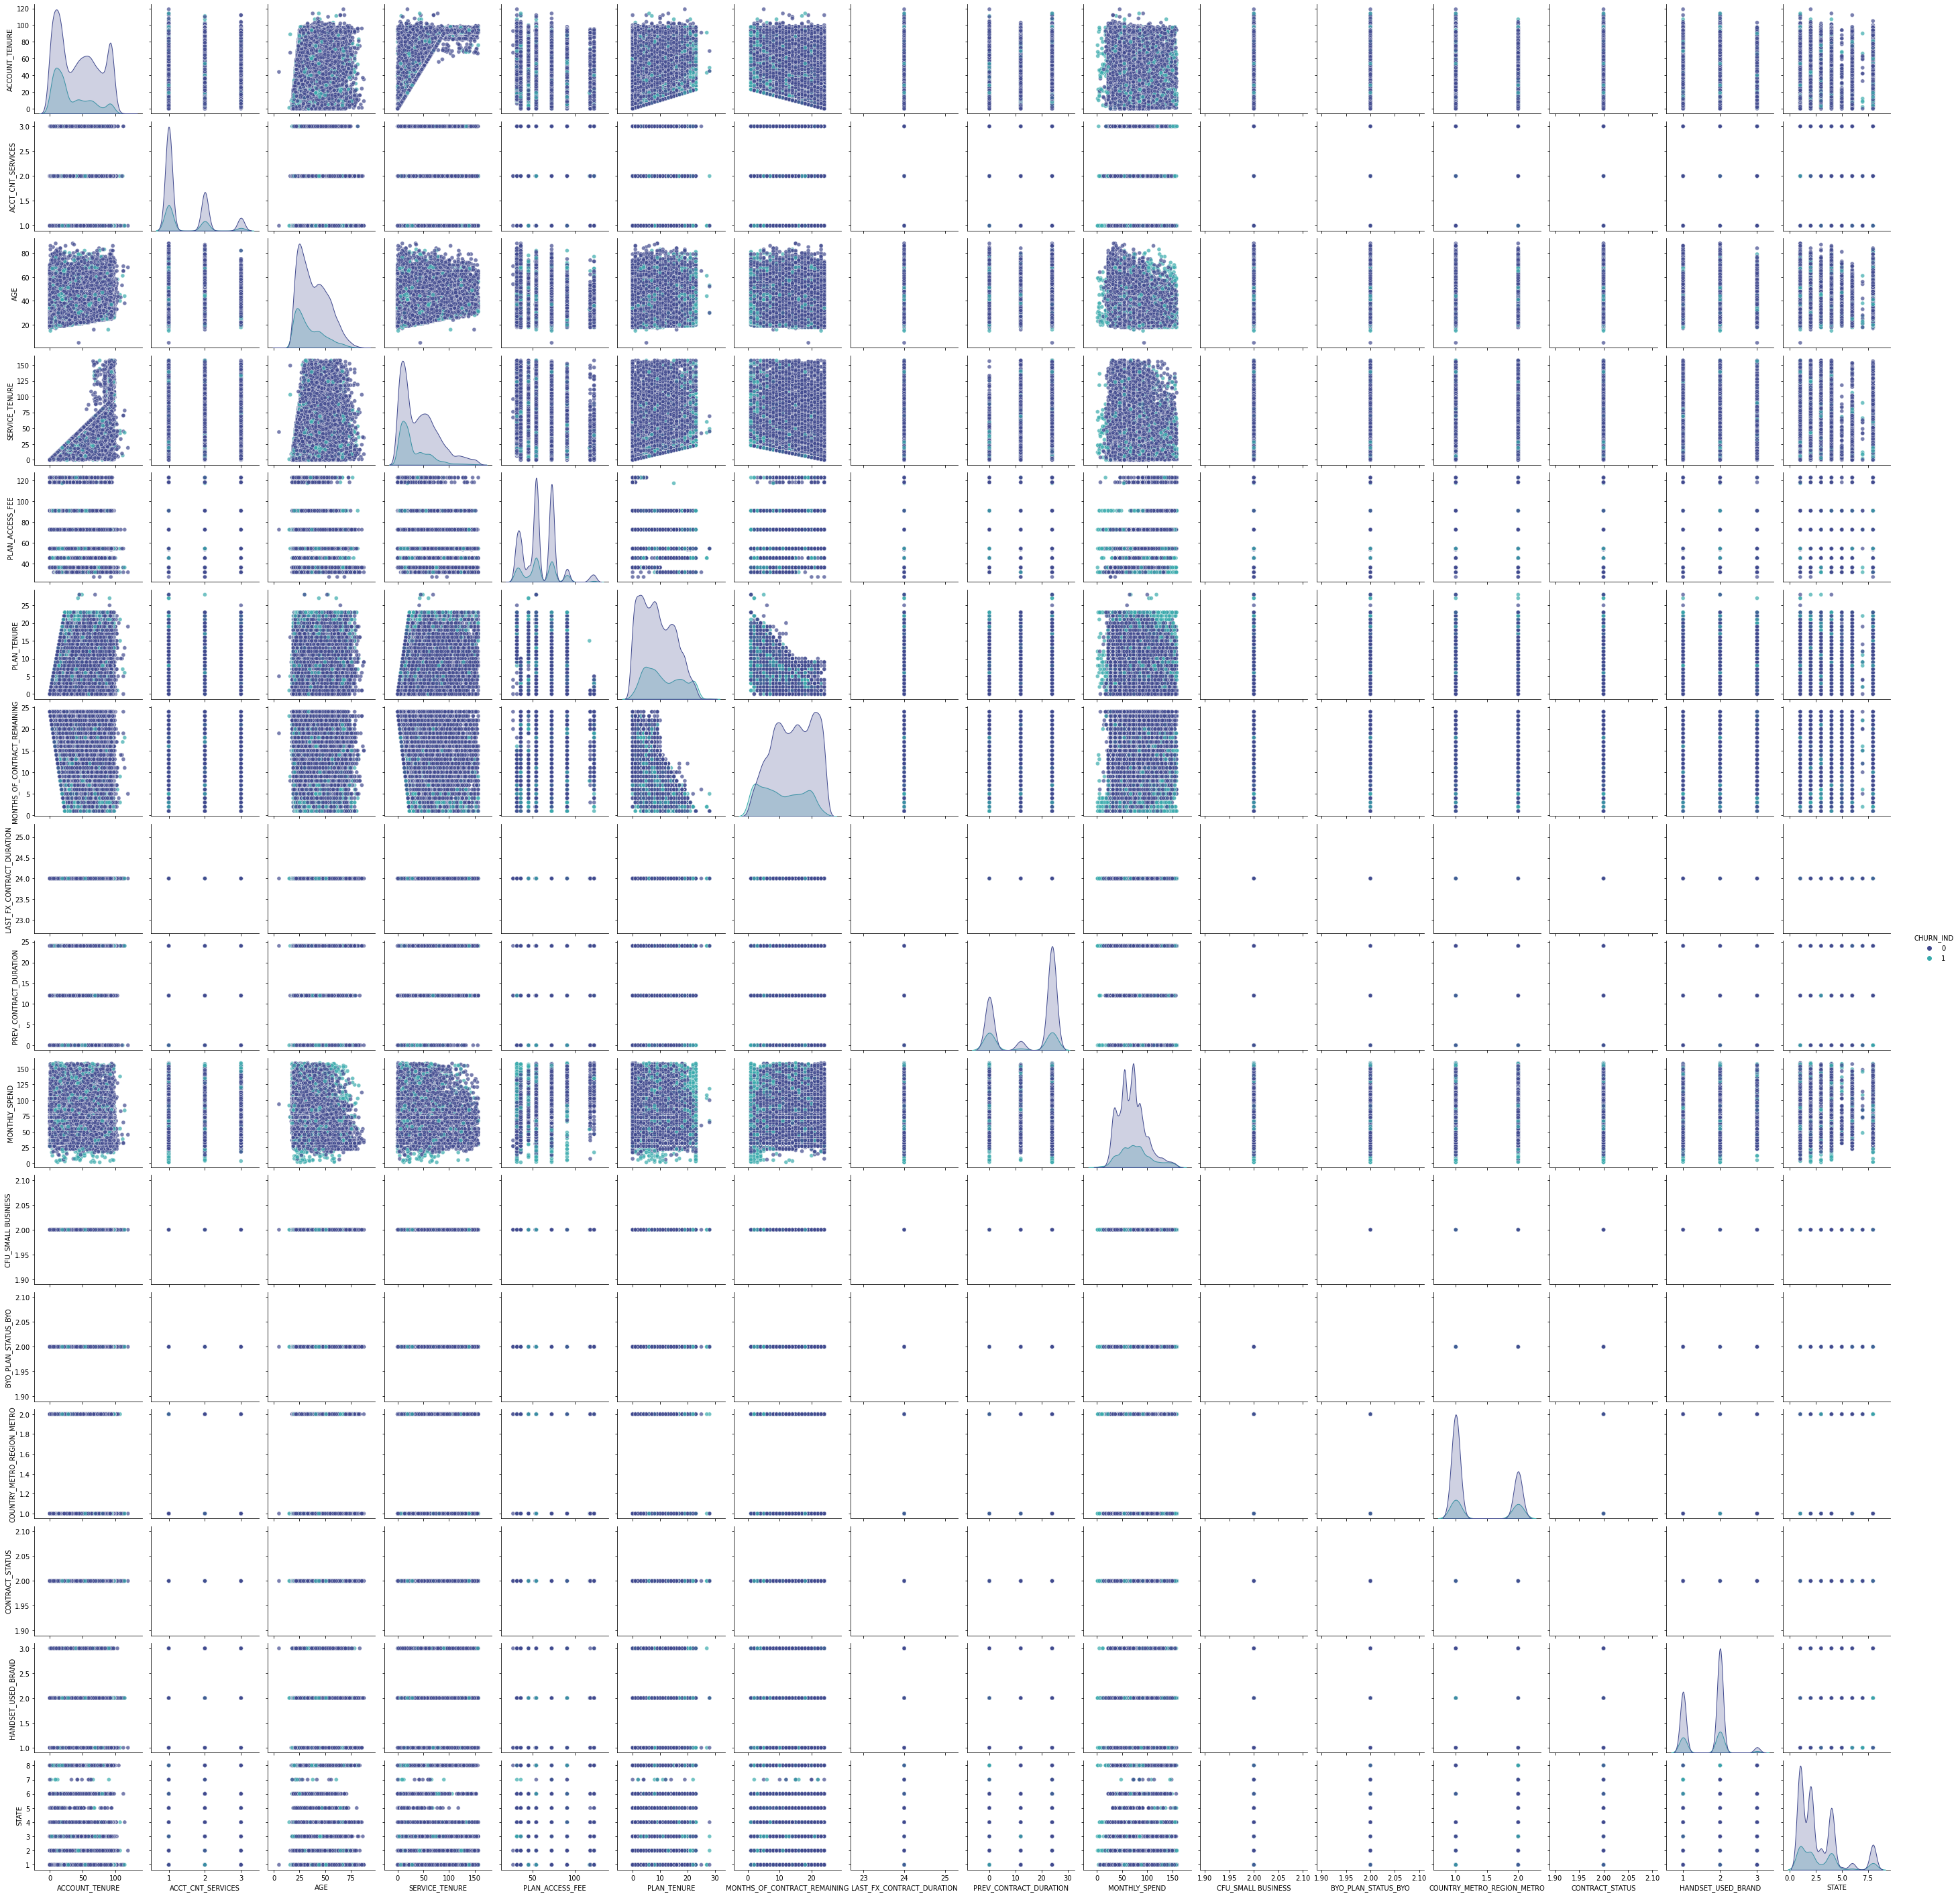

In [11]:
# Pairplot for original dataset
plt.figure(figsize = (80,70))
sns.pairplot(churn_num, hue = 'CHURN_IND',palette='mako', diag_kind = 'kde', plot_kws=dict(alpha = 0.7), diag_kws=dict(shade=True))

The pairplot shows that some features in the original is not normally distributed and have skewness. It is possible to use transformation.

## Prepare Transformed Data

In [16]:
c_trans = churn_num.copy()
# Log transformed data
#c_trans['lg_ACCOUNT_TENURE'] = np.log(c_trans['ACCOUNT_TENURE'])
c_trans['lg_ACCT_CNT_SERVICES'] = np.log(c_trans['ACCT_CNT_SERVICES'])
c_trans['lg_AGE'] = np.log(c_trans['AGE'])
#c_trans['lg_SERVICE_TENURE'] = np.log(c_trans['SERVICE_TENURE'])
c_trans['lg_PLAN_ACCESS_FEE'] = np.log(c_trans['PLAN_ACCESS_FEE'])
#c_trans['lg_PLAN_TENURE'] = np.log(c_trans['PLAN_TENURE'])
#c_trans['lg_MONTHS_OF_CONTRACT_REMAINING'] = np.log(c_trans['MONTHS_OF_CONTRACT_REMAINING'])
c_trans['lg_LAST_FX_CONTRACT_DURATION'] = np.log(c_trans['LAST_FX_CONTRACT_DURATION'])
#c_trans['lg_PREV_CONTRACT_DURATION'] = np.log(c_trans['PREV_CONTRACT_DURATION'])
c_trans['lg_MONTHLY_SPEND'] = np.log(c_trans['MONTHLY_SPEND'])
c_trans['lg_CFU_SMALL BUSINESS'] = np.log(c_trans['CFU_SMALL BUSINESS'])
c_trans['lg_BYO_PLAN_STATUS_BYO'] = np.log(c_trans['BYO_PLAN_STATUS_BYO'])
c_trans['lg_COUNTRY_METRO_REGION_METRO'] = np.log(c_trans['COUNTRY_METRO_REGION_METRO'])
c_trans['lg_CONTRACT_STATUS'] = np.log(c_trans['CONTRACT_STATUS'])
c_trans['lg_HANDSET_USED_BRAND'] = np.log(c_trans['HANDSET_USED_BRAND'])
c_trans['lg_STATE'] = np.log(c_trans['STATE'])
c_trans=c_trans.drop(['ACCT_CNT_SERVICES', 'AGE', 'PLAN_ACCESS_FEE', 'LAST_FX_CONTRACT_DURATION', 'MONTHLY_SPEND', 'CFU_SMALL BUSINESS', 'BYO_PLAN_STATUS_BYO', 'COUNTRY_METRO_REGION_METRO', 'CONTRACT_STATUS', 'HANDSET_USED_BRAND', 'STATE'], axis=1)
# 'ACCOUNT_TENURE','PLAN_TENURE', 'MONTHS_OF_CONTRACT_REMAINING', 'SERVICE_TENURE', 'PREV_CONTRACT_DURATION',
c_trans.head()

ACCOUNT_TENURE  SERVICE_TENURE  PLAN_TENURE  \
INDEX                                                
8                  12              12           12   
9                  13              13           13   
10                 90             125           11   
13                  9               9            9   
17                 33              33           11   

       MONTHS_OF_CONTRACT_REMAINING  PREV_CONTRACT_DURATION  CHURN_IND  \
INDEX                                                                    
8                                12                       0          1   
9                                11                       0          1   
10                               13                      24          1   
13                               15                      24          1   
17                                4                      24          1   

       lg_ACCT_CNT_SERVICES    lg_AGE  lg_PLAN_ACCESS_FEE  \
INDEX                                                       
8                  0.000000  4.189655            3.998934   
9                  0.000000  3.044522            3.998934   
10                 0.000000  3.713572            4.286616   
13                 0.000000  3.091042            4.286616   
17                 0.693147  2.995732            4.286616   

       lg_LAST_FX_CONTRACT_DURATION  lg_MONTHLY_SPEND  lg_CFU_SMALL BUSINESS  \
INDEX                                                                          
8                          3.178054          4.007151               0.693359   
9                          3.178054          4.194944               0.693359   
10                         3.178054          4.794881               0.693359   
13                         3.178054          4.286616               0.693359   
17                         3.178054          4.447814               0.693359   

       lg_BYO_PLAN_STATUS_BYO  lg_COUNTRY_METRO_REGION_METRO  \
INDEX                                                          
8                    0.693359                       0.000000   
9                    0.693359                       0.693359   
10                   0.693359                       0.693359   
13                   0.693359                       0.000000   
17                   0.693359                       0.000000   

       lg_CONTRACT_STATUS  lg_HANDSET_USED_BRAND  lg_STATE  
INDEX                                                       
8                0.693147               0.000000  0.000000  
9                0.693147               0.000000  0.693147  
10               0.693147               0.693147  2.079442  
13               0.693147               0.693147  0.000000  
17               0.693147               0.000000  0.693147

In [17]:
churn_num[churn_num['ACCOUNT_TENURE'] == 0].shape[0] #283
churn_num[churn_num['SERVICE_TENURE'] == 0].shape[0] #313
churn_num[churn_num['PLAN_TENURE'] == 0].shape[0] #806
churn_num[churn_num['PREV_CONTRACT_DURATION'] == 0].shape[0] #6129

6129

<Figure size 5760x5040 with 0 Axes>

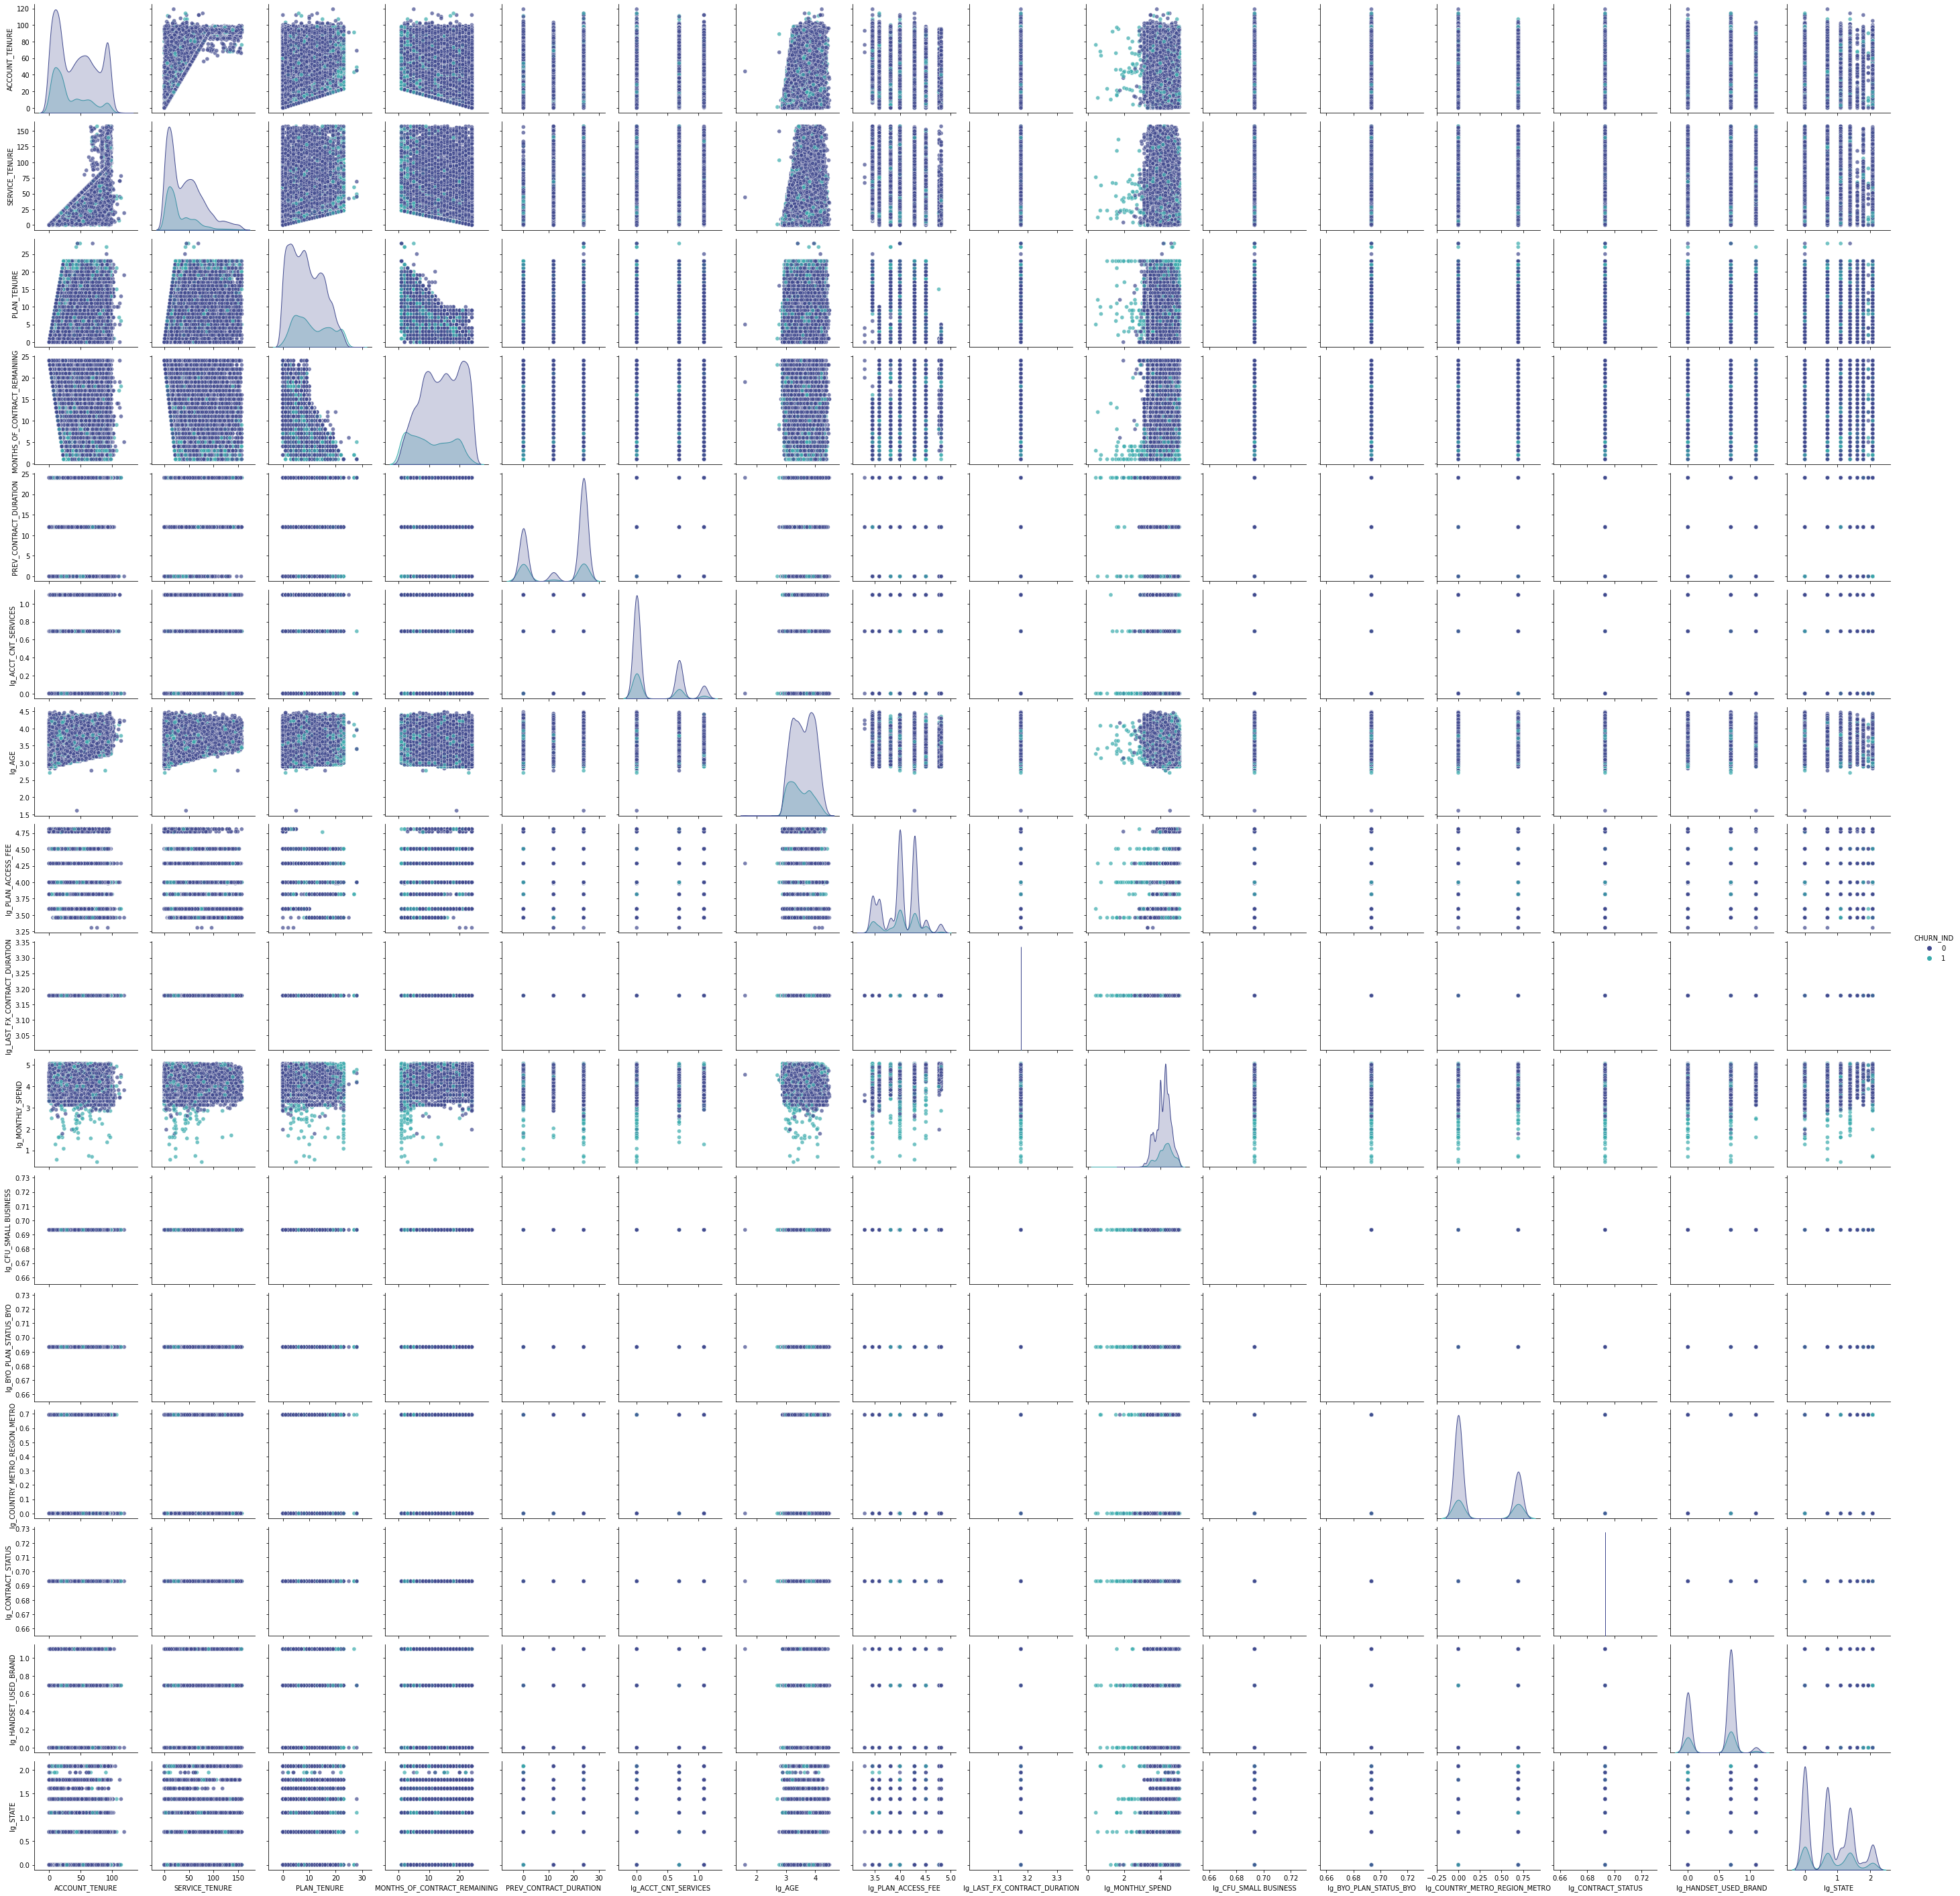

In [18]:
# sns.pairplot(reduced_churn, x_vars=churn.columns, y_vars=['CHURN_IND'])
plt.figure(figsize = (80,70))
sns.pairplot(c_trans, hue = 'CHURN_IND',palette='mako', diag_kind = 'kde', plot_kws=dict(alpha = 0.7), diag_kws=dict(shade=True))

In [19]:
c_trans=c_trans.dropna()

The data is more normally distributed after transformation.

## Logistics Regression Model For Original Data

In [124]:
#Remove because the RFE and pairpot shows that these features are not important
reduced_churn_num=churn_num.drop(['CFU_SMALL BUSINESS','BYO_PLAN_STATUS_BYO'], axis=1)

In [135]:
# Split data into training(80%) and testing data (20%) and use random_state=142
train, test = train_test_split(reduced_churn_num, test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

(13796, 15)
(3450, 15)


In [136]:
# Getting input data and targets for building prediction model
X_train = train.drop(['CHURN_IND'], axis=1) 
y_train = train['CHURN_IND']
X_test = test.drop(['CHURN_IND'], axis=1) 
y_test = test['CHURN_IND']

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print(X_train.head())
print(y_train.head())

X_train shape:  (13796, 14)
y_train shape:  (13796,)
X_test shape:  (3450, 14)
y_test shape:  (3450,)
       ACCOUNT_TENURE  ACCT_CNT_SERVICES   AGE  SERVICE_TENURE  \
INDEX                                                            
21809               0                  1  68.0               0   
36779              95                  2  30.0             118   
19229              14                  1  49.0              14   
27041              16                  3  49.0              16   
29624              16                  1  19.0              15   

       PLAN_ACCESS_FEE  PLAN_TENURE  MONTHS_OF_CONTRACT_REMAINING  \
INDEX                                                               
21809            72.72            0                            24   
36779            54.54           10                            14   
19229            54.54            6                            10   
27041            31.81           16                             8   
29624            72.7

In [137]:
# Training Logistic Regression model
model = LogisticRegression(max_iter=200, C=1.8)
model.fit(X_train, y_train)

LogisticRegression(C=1.8, max_iter=200)

In [138]:
# Doing predictions on train and test set
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)
# Evaluate the performance of your trained model
print("Accuracy score on training set: ", accuracy_score(y_train, y_hat_train))
print("Accuracy score on testing set: ", accuracy_score(y_test, y_hat_test))

Accuracy score on training set:  0.7830530588576399
Accuracy score on testing set:  0.7855072463768116


In [139]:
# Checking confusion matrix
print("Confusion matrix on test set: ")
print(confusion_matrix(y_test, y_hat_test))
print("Confusion matrix on train set: ")
print(confusion_matrix(y_train, y_hat_train))

Confusion matrix on test set: 
[[2546  113]
 [ 627  164]]
Confusion matrix on train set: 
[[10197   417]
 [ 2576   606]]


#### Summary
For Logistics Regression model on original data, the acccuracy score on training set is 78.31% and accuracy score on testing set is 78.55%. The acurracy score between the two set is quite similar, it means that the model is not overfitting or underfitting. The confusion matrix shows that there are 2576 churn_ind values of 1 is inaccurately predicted as 0 and there are 417 churn_ind values of 0 is inaccurately predicted as 1. This model might not be useful because the false positive and false negative cases are significantly large. 

## Logistics Regression Model For Transformed Data

In [99]:
# Split data into training(80%) and testing data (20%) and use random_state=142
ttrain, ttest = train_test_split(c_trans, test_size=0.2, random_state=142)
print(ttrain.shape)
print(ttest.shape)

(13796, 17)
(3450, 17)


In [100]:
# Getting input data and targets for building prediction model
X_ttrain = ttrain.drop(['CHURN_IND'], axis=1)
y_ttrain = ttrain['CHURN_IND']
X_ttest = ttest.drop(['CHURN_IND'], axis=1)
y_ttest = ttest['CHURN_IND']

print("X_train shape: ", X_ttrain.shape)
print("y_train shape: ", y_ttrain.shape)
print("X_test shape: ", X_ttest.shape)
print("y_test shape: ", y_ttest.shape)
print(X_ttrain.head())
print(y_ttrain.head())

X_train shape:  (13796, 16)
y_train shape:  (13796,)
X_test shape:  (3450, 16)
y_test shape:  (3450,)
       ACCOUNT_TENURE  SERVICE_TENURE  PLAN_TENURE  \
INDEX                                                
21809               0               0            0   
36779              95             118           10   
19229              14              14            6   
27041              16              16           16   
29624              16              15           15   

       MONTHS_OF_CONTRACT_REMAINING  PREV_CONTRACT_DURATION  \
INDEX                                                         
21809                            24                      24   
36779                            14                      24   
19229                            10                      24   
27041                             8                      24   
29624                             9                       0   

       lg_ACCT_CNT_SERVICES    lg_AGE  lg_PLAN_ACCESS_FEE  \
INDEX           

In [101]:
# Training Logistic Regression model
model = LogisticRegression(max_iter=200, C=1.8)
model.fit(X_ttrain, y_ttrain)

LogisticRegression(C=1.8, max_iter=200)

In [102]:
# Doing predictions on train and test set
y_hat_ttrain = model.predict(X_ttrain)
y_hat_ttest = model.predict(X_ttest)
# Evaluate the performance of your trained model
print("Accuracy score on training set: ", accuracy_score(y_train, y_hat_train))
print("Accuracy score on testing set: ", accuracy_score(y_test, y_hat_test))

Accuracy score on training set:  0.7831255436358365
Accuracy score on testing set:  0.7855072463768116


In [103]:
# Checking confusion matrix
print("Confusion matrix on test set: ")
print(confusion_matrix(y_ttest, y_hat_ttest))
print("Confusion matrix on train set: ")
print(confusion_matrix(y_ttrain, y_hat_ttrain))

Confusion matrix on test set: 
[[2549  110]
 [ 636  155]]
Confusion matrix on train set: 
[[10194   420]
 [ 2598   584]]


#### Summary
For Logistics Regression model on original data, the acccuracy score on training set is 78.31% and accuracy score on testing set is 78.55%. The acurracy score between the two set is quite similar, it means that the model is not overfitting or underfitting. Because the regression model of original data and transformed data is quite similar,  original data is used to join other predictive models.  

In [73]:
#Feature Selection
# creating RFE object
lr_model = LogisticRegression()
rfe = RFE(estimator=lr_model, n_features_to_select=5, step=1)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=5)

In [74]:
# summarize all features
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 4.000
Column: 1, Selected False, Rank: 3.000
Column: 2, Selected False, Rank: 2.000
Column: 3, Selected False, Rank: 8.000
Column: 4, Selected False, Rank: 7.000
Column: 5, Selected True, Rank: 1.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected False, Rank: 12.000
Column: 9, Selected False, Rank: 6.000
Column: 10, Selected False, Rank: 11.000
Column: 11, Selected False, Rank: 10.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected False, Rank: 9.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected False, Rank: 5.000


In [75]:
# Increment number of features, one at each time
acc_scores = []
for i in range(1,10):
    clf = LogisticRegression()
    rfe = RFE(estimator=clf, n_features_to_select=i)
    # training model
    rfe.fit(X_train, y_train)
    # predicting on test set
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    # print this
    print("Acc on test set using", i, "features: ", acc_score)
    # append to the list
    acc_scores.append(acc_score)

Acc on test set using 1 features:  0.7707246376811594
Acc on test set using 2 features:  0.7753623188405797
Acc on test set using 3 features:  0.7744927536231884
Acc on test set using 4 features:  0.7747826086956522
Acc on test set using 5 features:  0.7747826086956522
Acc on test set using 6 features:  0.7794202898550725
Acc on test set using 7 features:  0.78
Acc on test set using 8 features:  0.78
Acc on test set using 9 features:  0.7791304347826087


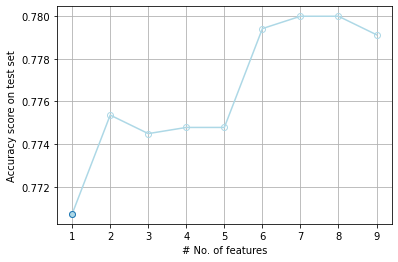

In [76]:
# Estimating accuracy score on test set using RFE by using different number of features
estimator = LogisticRegression()
acc_scores = []
for i in range(1, 10):
    selector = RFE(estimator, i)
    selector = selector.fit(X_train, y_train)
    supp = selector.get_support()

    predicted = selector.predict(X_test)
    acc_score = accuracy_score(y_test, predicted)
    acc_scores.append(acc_score)
  
best = 1
for item in acc_scores:
    if item < acc_scores[best - 1]:
        best = acc_scores.index(item) + 1

plt.grid()   
plt.xlabel('# No. of features')
plt.ylabel('Accuracy score on test set')
plt.plot(range(1, 10), acc_scores, marker = 'o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'lightblue', markerfacecolor = 'None')
plt.plot(best, acc_scores[best-1], marker = 'o', markerfacecolor = 'lightblue')

In [77]:
print("Feature names: \n", churn_num.columns)
print("Target names: \n", churn_num['CHURN_IND'].unique())
print("Target values: \n", churn_num['CHURN_IND'].values)

Feature names: 
 Index(['ACCOUNT_TENURE', 'ACCT_CNT_SERVICES', 'AGE', 'SERVICE_TENURE',
       'PLAN_ACCESS_FEE', 'PLAN_TENURE', 'MONTHS_OF_CONTRACT_REMAINING',
       'LAST_FX_CONTRACT_DURATION', 'PREV_CONTRACT_DURATION', 'CHURN_IND',
       'MONTHLY_SPEND', 'CFU_SMALL BUSINESS', 'BYO_PLAN_STATUS_BYO',
       'COUNTRY_METRO_REGION_METRO', 'CONTRACT_STATUS', 'HANDSET_USED_BRAND',
       'STATE'],
      dtype='object')
Target names: 
 [1 0]
Target values: 
 [1 1 1 ... 0 0 0]


### KNN Classifier Model

In [153]:
#Advanced methods
# KNN classifier model
clf_knn = KNeighborsClassifier(n_neighbors=4)

# Train the model with the training data
clf_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [154]:
y_pred=clf_knn.predict(X_test)
accuracy=accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7802898550724637


[0.71014493 0.75652174 0.74028986 0.72985507 0.71884058 0.7484058
 0.725058   0.71925754 0.74651972 0.73317865]
[0.7826087  0.78666667 0.79246377 0.77217391 0.77913043 0.7773913
 0.77842227 0.80452436 0.7900232  0.78364269]
[0.78724638 0.79246377 0.79478261 0.78318841 0.78144928 0.78608696
 0.80394432 0.79582367 0.79118329 0.78480278]
[0.7942029  0.80347826 0.7942029  0.78318841 0.78608696 0.78608696
 0.7987239  0.7987239  0.78074246 0.78190255]
[0.78608696 0.79536232 0.77913043 0.79246377 0.79478261 0.79188406
 0.7900232  0.7900232  0.78770302 0.80510441]
[0.78898551 0.7942029  0.77391304 0.77971014 0.80985507 0.79014493
 0.79640371 0.79292343 0.79466357 0.78654292]
[0.80231884 0.77449275 0.78724638 0.77565217 0.79942029 0.79536232
 0.78770302 0.78944316 0.78712297 0.79466357]
[0.79188406 0.79246377 0.80289855 0.81333333 0.7773913  0.78376812
 0.77146172 0.79698376 0.77030162 0.77784223]
[0.8        0.78434783 0.79362319 0.78608696 0.76753623 0.80463768
 0.80452436 0.7737819  0.770881

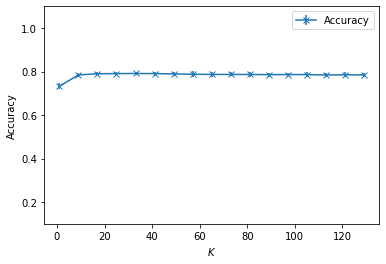

In [145]:
#Data without y
data=reduced_churn_num.drop(['CHURN_IND'], axis=1)
#Parameter Tuning with Cross Validation (CV)
cv_scores = []
cv_scores_std = []
k_range = range(1, 135, 8)
for i in k_range:
    clf = KNeighborsClassifier(n_neighbors = i)
    scores = cross_val_score(clf, data, reduced_churn_num['CHURN_IND'].values, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True))
    print(scores)
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

# Plot the relationship
print(cv_scores)
print(cv_scores_std)
plt.errorbar(k_range, cv_scores, yerr=cv_scores_std, marker='x', label='Accuracy')
plt.ylim([0.1, 1.1])
plt.xlabel('$K$')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [146]:
parameter_grid={'n_neighbors': range(1, 135, 8)}
knn_clf=KNeighborsClassifier()
gs_knn=GridSearchCV(knn_clf, parameter_grid, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=42))
gs_knn.fit(data, reduced_churn_num['CHURN_IND'])
print('Best K: ', gs_knn.best_params_['n_neighbors'])
print('Accuracy: ', gs_knn.best_score_)

Best K:  25
Accuracy:  0.7905022024950401


### Summary
* KNN Classifier Model has the accuracy score of 79.05%. The KNN Classifier Model returns higher accuracy score than Logistics Model. Therefore, KNN Classifier Model could be choosen as the alternative of Logistics Model to predict the churn data.
* After using an eclectic mix of methods, the accuracy result remain low and some more advanced model should be used to predict the churn data.